In [21]:
from __future__ import division, print_function
from keras.utils import np_utils
# from scipy.misc import imresize
import itertools
import time
import matplotlib.pyplot as plt
import numpy as np  
import random
from PIL import Image
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, AveragePooling2D, MaxPooling2D, UpSampling2D, Input, Reshape, Lambda, merge, Concatenate, Subtract, Reshape, multiply
from keras.layers import Embedding, ZeroPadding2D
from keras.regularizers import l2
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
from keras.optimizers import Nadam, Adam, SGD
from keras.metrics import categorical_accuracy, binary_accuracy
from keras.callbacks import Callback, History
import tensorflow as tf
import pandas as pd
import glob
import PIL
from sys import getsizeof
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.ticker import MaxNLocator
from sklearn.utils import class_weight

from keras.datasets import mnist

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 512)               401920    
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_43 (Dense)            (None, 512)               262656    
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 512)               0         
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_44 (Dense)            (None, 512)               262656    
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 512)             

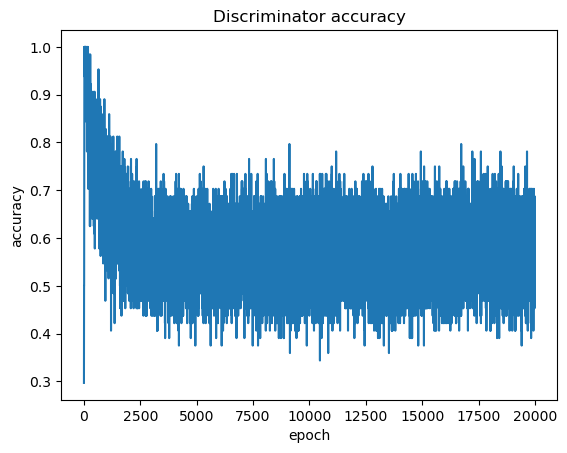

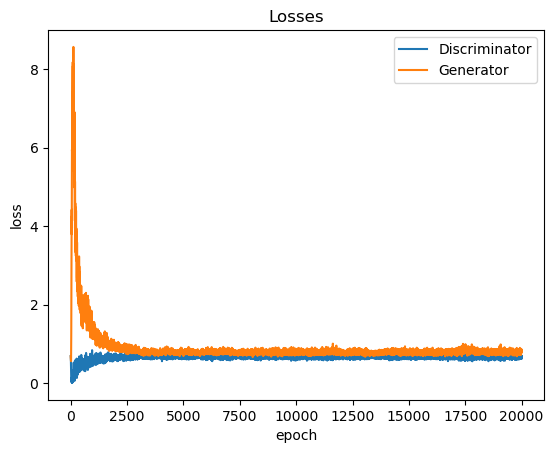

In [23]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Image shape information
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
if len(X_train.shape) == 4:
    channels = X_train.shape[3]
else:
    channels = 1
img_shape = (img_rows, img_cols, channels)
num_classes = 10
latent_dim = 100
optimizer = Adam(0.0002, 0.5)

# Generator
def generator():

    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label))

    model_input = multiply([noise, label_embedding])
    img = model(model_input)

    return Model([noise, label], img)

# Discriminator
def discriminator():

    model = Sequential()

    model.add(Dense(512, input_dim=np.prod(img_shape)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    label = Input(shape=(1,), dtype='int32')

    label_embedding = Flatten()(Embedding(num_classes, np.prod(img_shape))(label))
    flat_img = Flatten()(img)

    model_input = multiply([flat_img, label_embedding])

    validity = model(model_input)

    return Model([img, label], validity)

# Build and compile the discriminator
discriminator = discriminator()
discriminator.compile(loss=['binary_crossentropy'], optimizer=optimizer, metrics=['accuracy'])

# Build the generator
generator = generator()

# The generator takes noise and the target label as input
# and generates the corresponding digit of that label
noise = Input(shape=(latent_dim,))
label = Input(shape=(1,))
img = generator([noise, label])

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated image as input and determines validity
# and the label of that image
valid = discriminator([img, label])

# The combined model  (stacked generator and discriminator)
# Trains generator to fool discriminator
combined = Model([noise, label], valid)
combined.compile(loss=['binary_crossentropy'], optimizer=optimizer)

#Function which save the generated 10 digits after every 'sample_interval'(here 200) number of epochs
def sample_images(epoch):
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    sampled_labels = np.arange(0, 10).reshape(-1, 1)

    gen_imgs = generator.predict([noise, sampled_labels])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
            axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("%d.png" % epoch)
    plt.close()

epochs=20000
batch_size=32
sample_interval=200

# Training both Discriminator and Generator

# Configure input
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)
y_train = y_train.reshape(-1, 1)
    
# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))
    
# Declaring empty lists to save the losses for plotting
d_loss_plot = []
g_loss_plot = []
acc_plot = []

for epoch in range(epochs):

    #Training the Discriminator

    # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs, labels = X_train[idx], y_train[idx]

    # Sample noise as generator input
    noise = np.random.normal(0, 1, (batch_size, 100))

    # Generate a half batch of new images
    gen_imgs = generator.predict([noise, labels])

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch([imgs, labels], valid)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    #Training the Generator

    # Condition on labels
    sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

    # Train the generator
    g_loss = combined.train_on_batch([noise, sampled_labels], valid)

    # Saving the Discriminator and Generator losses and accuracy for plotting
    d_loss_plot.append(d_loss[0])
    g_loss_plot.append(g_loss)
    acc_plot.append(d_loss[1])
    
    # Plot the progress every 100 epochs
    if epoch % 100 == 0:
        print ("%d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, epochs, d_loss[0], 100*d_loss[1], g_loss))

    # Saving generated image samples at every sample interval
    if epoch % sample_interval == 0:
        sample_images(epoch)


# Ploting losses and accuracy

# Discriminator accuracy plot 
plt.plot(acc_plot)
plt.title('Discriminator accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Loss plots
plt.plot(d_loss_plot)
plt.plot(g_loss_plot)
plt.title('Losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Discriminator', 'Generator'])
plt.show()

1/1 [==============================] - 0s 36ms/step


C:\Users\cjabz\anaconda3\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


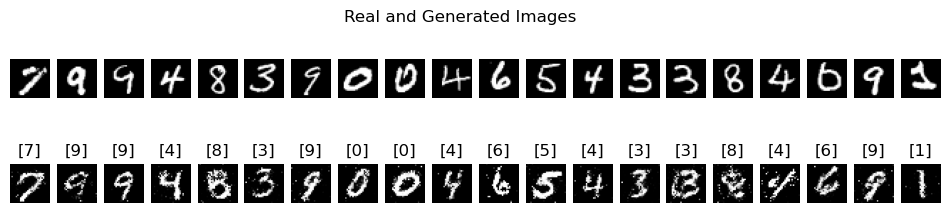

In [29]:
def m_inp(N):
    idx = np.random.randint(0, X_train.shape[0], N)
    d_n = X_train[idx]
    l_n = y_train[idx]
    g_n_noise = np.random.normal(0, 1, (N, latent_dim))
    return d_n, l_n, g_n_noise

N = 20
d_n, l_n, g_n_noise = m_inp(N)
gen_imgs = generator.predict([g_n_noise, l_n])
d_n = 0.5 * d_n + 0.5
gen_imgs = 0.5 * gen_imgs + 0.5
fig, axs = plt.subplots(2, N, figsize=(12, 2.5))
fig.suptitle('Real and Generated Images')
for i in range(N):
    axs[0, i].imshow(d_n[i].reshape(28, 28), cmap='gray')
    axs[1, i].title.set_text(l_n[i])
    axs[1, i].imshow(gen_imgs[i].reshape(28, 28), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].axis('off')
plt.show()

In [34]:
conda install -c conda-forge opencv 

^C

Note: you may need to restart the kernel to use updated packages.


In [35]:
import numpy as np
from skimage.metrics import mean_squared_error
import scipy
from skimage.metrics import structural_similarity as ssim
from scipy.spatial.distance import euclidean as e_dist
#
sz = 784 * 3
image1 = np.arange(sz).reshape(28, 28, 3) / sz
image2 = np.arange(sz).reshape(28, 28, 3) / sz + 0.1
#
# Средняя квадратическая ошибка
mse = ((image1 - image2) ** 2).mean()
mse2 = mean_squared_error(image1, image2)
# Пиковое отношение сигнала к шуму
# https://habr.com/ru/articles/126848/
psnr = cv2.PSNR(image1, image2, mse)
# Индекс структурного сходства
# https://habr.com/ru/articles/126848/
# https://scikit-image.org/docs/stable/auto_examples/transform/plot_ssim.html
score_ssim, diff = ssim(image1, image2, full = True, multichannel = True)

score_ssim, diff = ssim(image1, image2, full = True, channel_axis = 2)
score_ssim2, diff = ssim(image1.flatten(), image2.flatten(), full = True)
# Евклидово расстояние
ec_dst = np.linalg.norm(image1 - image2)
ec_dst2 = e_dist(image1.flatten(), image2.flatten())
# Косинусное расстояние между векторами
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html
cs_dst = scipy.spatial.distance.cosine(image1.flatten(), image2.flatten())

print('mse =', mse)
print('mse2 =', mse2)
print('psnr =', psnr)
print('ssim =', score_ssim)
print('ssim2 =', score_ssim2)
print('ec_dst =', ec_dst)
print('ec_dst2 =', ec_dst2)
print('cs_dst =', cs_dst)

NameError: name 'cv2' is not defined